# Outline of the notebook


TODO (@christy) -- please modify the titles / wording to match the titles
- Defining a MDP for recommendation system using gym API (15 min)
- Online RL - Bandits (15 min)
- Online RL - DQN (15 min)
- Break (5 min)
- Offline RL - (15 min)


# Creating a RecSys gym environement

TODO (Kourosh) make this transition nice with bullet point and less text.

RL is usually a fit when it comes to sequential decision making problems. For example in recommendation systems, the particular items that our AI recommends could impact the interest profile of the users that it interacts with and as result, can have consequences on the next time-step that it is making a decision. This is in contrast to the passive prediction problems where the task is simply to predict the future and that prediction does not change the outcome.

To successfully train RL agents we usually need a good simulator that can approximate real-world behavior about what is going to happen if your agent takes certain actions. It is always recomended to start with an environement that can be used to emulate real-world behavior. 

In this section, we will learn how to create and evaluate an exemplar RecSys environment using gym API. 

## RecSim

In this notebook, we will use <b><a href="https://github.com/google-research/recsim">Google's RecSim environment</a></b>, which was developed for the YouTube recommendation problem.  It is a configurable environment, where ideally you would plug in your own users, products, and embedding features.

**Some further readings**

- <a href="https://github.com/google-research/recsim">RecSim github</a>
- <a href="https://arxiv.org/pdf/1909.04847.pdf">RecSim paper</a>

The following image depicts all the components of the recsim packages:

<img src="./images/recsim_environment.png" width="70%" />

The environment is <i>Timelimit-based</i>, meaning the termination condition for an episode will be after a fixed number (10) of videos are watched. 

### Document Model
Documents represent the candidate pool of items that need to be recommended with features sampled in the range [0, 1].  In this tutorial, we use <b>1 single feature "sweetness"</b> drawn from a uniform distribution between [0.8, 1.0] to represent "chocolaty" items and [0, 0.2] for the "kaley" options. 
- The documents can be different at each step (produced by some "candidate generation" process), or fixed throughout the simulation.
- The recommendation algorithm observes the D candidate documents.  It then makes a selection (possibly ordered) of k documents and presents them in a "slate" to the user. We will focus on **slate size of 1** in this tutorial. 

### User Model
In RecSim users are representation by a set of features some of which could be latent hidden variables not observed by our recommendation system during live interaction. In this tutorial we assume that a sampled user from the world does not own any observable features like age, gender, etc. and our AI should infer the latent state of the user from its history of interactions in the current session. 
- The user examines a "slate" of recommended items and makes a choice of one item. After making their choice, the user emits an engagement score which indicates how much that user was engaged with that particular item they chose. The agent has to learn to estimate the latent states of the user that shape their choice model in the future. 

### User Choice
This module controls how a particular user would respond to a set of recommendations and how its latent state would evolve as a function of this interaction. 
In the environment in this tutorial, engagement is assumed to be a function of two competing phenomenas:
-   The love of the user for sweet items ($sweetness(item_t)$)
-   The long term satisfaction which cares about healthier options. It is inversely correlated with the sweetness of items suggested so far ($satisfaction_{t-1}$)

$$satisfaction_t := satisfaction_{t-1} * \sigma(-sweetness(item_{t}))$$
$$r(item_t) \propto sweetness(item_t) * satisfaction_{t-1}$$

i.e. If a user who loves chocolates have not had chocolate for a while, a chocolate item would be more engaging than a kaley item. On the other hand if we keep recommending chocolate to the same person, they may lose interest and not use our recommendations. 


Let's look at this enviornement properties closer:

In [1]:
# import os; os.environ["PATH"] = "/home/ray/anaconda3/bin:" + os.environ["PATH"]
# !pip uninstall -y torch
# !python -m pip install torch==1.12.1

In [2]:
import time
import random
import numpy as np
from pprint import pprint
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from ray import tune, air, data

import recsim 
from rllib_recsim.rllib_recsim import ModifiedLongTermSatisfactionRecSimEnv

Matplotlib is building the font cache; this may take a moment.
/home/ray/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2022-09-13 19:14:40.754315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ray/anaconda3/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-13 19:14:40.754336: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# main parameters
seed = 100
num_candidates = 20
reward_scale = 1.0

In [4]:
# Let's first instantiate the environment

config = {
    # The number of possible documents/videos/candidates that we can recommend
    "num_candidates": num_candidates,  
    # The number of recommendations that we will be making
    "slate_size": 1, 
    # Set to False for re-using the same candidate documents each timestep.
    "resample_documents": True,
    # Use consistent seeds for the environment ...
    "seed": seed,
    # scale rewards with this factor
    "reward_scale": reward_scale,
}

env = ModifiedLongTermSatisfactionRecSimEnv(config)
print(env)

<ModifiedLongTermSatisfactionRecSimEnv<RecSimRewardScalingWrapper<MultiDiscreteToDiscreteActionWrapper<RecSimObservationSpaceWrapper<RecSimResetWrapper<RecSimGymEnv instance>>>>>>


TODO (kourosh): add the source code link

The printed environement shows a hierarchy of wrappers around the main RecSim environment. Next we'll investigate the behavior of observation and action space. For more info on how the environement is actually implemented we refer you to the source code acompanied with this tutorial (link). 

In [5]:
# Let's checkout the observation space and action space
print("observation_space:")
print("-"*20)
print(env.observation_space)
print("observation_space example:")
print("-"*20)
print(env.observation_space.sample())
print("observation space keys:")
print("-"*20)
print(list(env.observation_space.keys()))

observation_space:
--------------------
Dict(user:Box([], [], (0,), float32), doc:Dict(0:Box([0.], [1.], (1,), float32), 1:Box([0.], [1.], (1,), float32), 2:Box([0.], [1.], (1,), float32), 3:Box([0.], [1.], (1,), float32), 4:Box([0.], [1.], (1,), float32), 5:Box([0.], [1.], (1,), float32), 6:Box([0.], [1.], (1,), float32), 7:Box([0.], [1.], (1,), float32), 8:Box([0.], [1.], (1,), float32), 9:Box([0.], [1.], (1,), float32), 10:Box([0.], [1.], (1,), float32), 11:Box([0.], [1.], (1,), float32), 12:Box([0.], [1.], (1,), float32), 13:Box([0.], [1.], (1,), float32), 14:Box([0.], [1.], (1,), float32), 15:Box([0.], [1.], (1,), float32), 16:Box([0.], [1.], (1,), float32), 17:Box([0.], [1.], (1,), float32), 18:Box([0.], [1.], (1,), float32), 19:Box([0.], [1.], (1,), float32)), response:Tuple(Dict(click:Discrete(2), engagement:Box(-1.0, 100.0, (), float32))), time:Box([-0.5], [0.5], (1,), float32))
observation_space example:
--------------------
OrderedDict([('user', array([], dtype=float32)), ('

The observation space is a dictionary of four keys. 
- The `user` key is empty, because there is no observable user features. 
- The `doc` key contains a set of documents presented with numerical keys. Each doc item has a scalar score representing its sweetness. 
- The `response` key includes a single record of `click` and `engagement` from the immediate previous interaction. 
- The `time` shows a normalized timestep within the session for this user. -0.5 corresponds to the beginnig of the interaction and +0.5 corresponds to the end of the interaction.

In [6]:
# Let's checkout the action space
print("action_space:")
print("-"*20)
print(env.action_space)
print("action_space example:")
print("-"*20)
print(env.action_space.sample())


action_space:
--------------------
Discrete(20)
action_space example:
--------------------
0


The action space is simply an integer number between 0, 19 (`Discrete(20)`). 

Let's now checkout environement's reward behavior. Let's see what happens if we always pick the sweetest item and plot the reward over time.

In [7]:
# Let's checkout the reward space
# TODO: code here
obs = env.reset()
rewards = []
done = False
while not done:
    action = int(max(obs["doc"], key=lambda x: obs["doc"][x]))
    obs, reward, done, info = env.step(action)
    rewards.append(reward)

Text(0.5, 0, 'step')

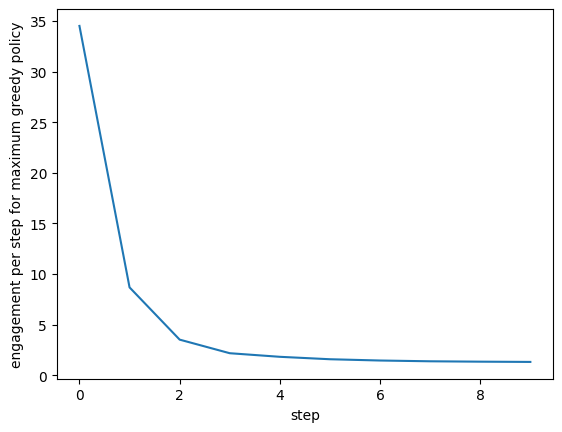

In [8]:
plt.plot(rewards)
plt.ylabel('engagement per step for maximum greedy policy')
plt.xlabel('step')

We can note a couple of things here already:

1. The imediate engagement would be high initially when the sweetest item is suggested for the first time.
2. As we keep recommending the sweetest items, the user satisfaction significantly tampers off and as a result engagement quickly drops.
3. Episodes seem to last for 10 timesteps.

#### Exercise (2 min):
Instead of picking the item with the highest feature, pick the item with the lowest feature and see what happens?

- What do your observations imply about this environment?
- What policy maximizes engagement with the user?

In [9]:
obs = env.reset()
rewards = []
done = False
while not done:
    # TODO (exercise): code here
    action = int(min(obs["doc"], key=lambda x: obs["doc"][x]))
    obs, reward, done, info = env.step(action)
    rewards.append(reward)

Text(0.5, 0, 'step')

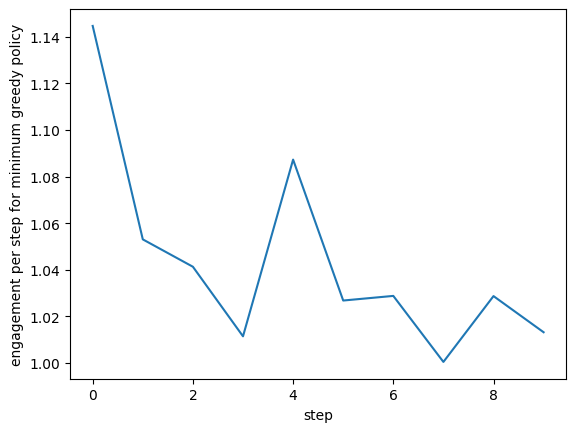

In [10]:
plt.plot(rewards)
plt.ylabel('engagement per step for minimum greedy policy')
plt.xlabel('step')

### Getting some baseline policies
Next we will run some simple baselines to get a feeling of the reward we can accumulate in these enviornements using simple policies.

- Greedy minimum feature value (recommending the kaliest option)
- Greedy maximum feature value (recommending the chocoletiest option)
- random policy (recommending random items from the pool)
- even argmin (recommmending alternations between argmax and argmin to keep the engagement high)


In [11]:
# Function that measures and outputs the random baseline reward.
# This computes  the expected accumulated reward per episode, if we act randomly (recommend random items) at each time step.
def calc_baseline(baseline_type="random",
                  episodes=100):

    env_config = {
        # The number of possible documents/videos/candidates that we can recommend
        # no flattening necessary (see `convert_to_discrete_action_space=False` below)
        "num_candidates": num_candidates,  
        # The number of recommendations that we will be making
        "slate_size": 1, 
        # Set to False for re-using the same candidate documents each timestep.
        "resample_documents": True,
        # Use consistent seeds for the environment ...
        "seed": seed,
        # scale rewards with this factor
        "reward_scale": reward_scale,
    }

    env = ModifiedLongTermSatisfactionRecSimEnv(env_config)
    # Reset the env.
    obs = env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    epsiode_satisfaction = []
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []
    episode_satisfactions = []
    
    # Enter while loop (to step through the episode).
    time_step = 0
    while num_episodes < episodes:
        # Produce an action
        # TODO: code here
#         random_action = ...
#         argmax_action = ...
#         argmin_action = ...
        random_action = env.action_space.sample()
        argmax_action = int(max(obs['doc'], key=lambda x: obs['doc'][x]))
        argmin_action = int(min(obs['doc'], key=lambda x: obs['doc'][x]))
        

        action_dict = {
            'argmax': argmax_action, # greedy choc
            'argmin': argmin_action, # greedy kale
            'random': random_action,
        }
        # a baseline that performs argmax in even time steps and argmin in odd time steps
        action_dict["even_argmin"] = (
            action_dict["argmin"] if time_step % 2 == 0 else action_dict["argmax"]
        )
        action = action_dict[baseline_type]
        
        # Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, _ = env.step(action)
        
        # Accumulate the rewards
        episode_reward += reward
        
        # Append satisfaction to episode_satiscation
        epsiode_satisfaction.append(
            env.environment._user_model._user_state.satisfaction
        )

        time_step += 1
        # Check, whether the episde is done, if yes, reset and increase episode counter.
        if done:
            if num_episodes % 99 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 9 == 0:
                print(".", end="")
                
            # increment on end of episode
            num_episodes += 1
            time_step = 0
            obs = env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0
            episode_satisfactions.append(np.mean(epsiode_satisfaction))

    # Print out and return mean episode reward (and standard error of the mean).
    env_mean_reward = np.mean(episode_rewards)
    env_sd_reward = np.std(episode_rewards)

    # Print out the satisfaction over the episodes
    env_mean_satisfaction = np.mean(episode_satisfactions)
    env_sd_satisfaction = np.std(episode_satisfactions)
    
    print(f"\nMean {baseline_type} baseline reward: {env_mean_reward:.2f}+/-{env_sd_reward:.2f}, satisfaction: {env_mean_satisfaction:.2f}+/-{env_sd_satisfaction:.2f}")

    return env_mean_reward, episode_rewards

In [12]:
num_episodes = 1000
kaliest_baseline, _ = calc_baseline(baseline_type="argmin", episodes=num_episodes)
sweetest_baseline,  _ = calc_baseline(baseline_type="argmax", episodes=num_episodes)
random_baseline, _ = calc_baseline(baseline_type="random", episodes=num_episodes)
even_margin_baseline, _ = calc_baseline(baseline_type="even_argmin", episodes=num_episodes)

 0 .......... 99 .......... 198 .......... 297 .......... 396 .......... 495 .......... 594 .......... 693 .......... 792 .......... 891 .......... 990 .
Mean argmin baseline reward: 10.87+/-0.26, satisfaction: 0.91+/-0.00
 0 .......... 99 .......... 198 .......... 297 .......... 396 .......... 495 .......... 594 .......... 693 .......... 792 .......... 891 .......... 990 .
Mean argmax baseline reward: 56.56+/-1.37, satisfaction: 0.14+/-0.00
 0 .......... 99 .......... 198 .......... 297 .......... 396 .......... 495 .......... 594 .......... 693 .......... 792 .......... 891 .......... 990 .
Mean random baseline reward: 99.37+/-24.05, satisfaction: 0.54+/-0.01
 0 .......... 99 .......... 198 .......... 297 .......... 396 .......... 495 .......... 594 .......... 693 .......... 792 .......... 891 .......... 990 .
Mean even_argmin baseline reward: 172.15+/-4.59, satisfaction: 0.57+/-0.00


#### Discussion about the baselines

For every baseline we have printed out not only the engagement score of the entire user session but also the average of the satisfaction term over the entire session as well.
- **Random policy beats greedy options**
- **Alternation between argmax and argmin beats random**

The question is whether we automatically learn an optimal policy in this recommendation enviornement?


## Questions (2 min)

- Any questions so far?

## Train a contextual bandit on the environement

Bandit is a classical algorithm used in RecSys that is known to optimize single-step objectives. **They maximize immediate engagement not accumulated engagement over the user session.**

Any RL algorithm can be turned into a contextual bandit algorithm if the discount factor of the Markov Decision Process is set to 0.0. This will result in maximizing the immediate reward and hence a bandit solution. 

In this section, we will use [DQN](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#dqn) to train an agent both with $\gamma = 0$ and $\gamma = 0.99$ to see the difference between a bandit solution and an RL solution.

In the config below we set a few settings:
- For the environement, we specify 20 candidates that are randomly re-sampled at each time-step.
- We use the torch implementation of the algorithm in RLlib
- For evaluation, we rollout 100 complete episodes at the end of each training iteration and compute the average of un-discounted reward over the episode


In [13]:
# use tune to register the environment
tune.register_env("modified-lts", 
    lambda config: ModifiedLongTermSatisfactionRecSimEnv(config)
)

In [14]:
from ray.rllib.algorithms.dqn import DQNConfig, DQN

In [15]:
# set up the environment config
env_config = {
    "num_candidates": num_candidates,  
    "slate_size": 1, 
    "resample_documents": True,
    "seed": seed,
    "reward_scale": reward_scale
}

bandit_config = DQNConfig()
# setup the env
bandit_config = bandit_config.environment(env="modified-lts", env_config=env_config)
# setup framework to be torch
bandit_config = bandit_config.framework("torch")
# setup the gamma
bandit_config = bandit_config.training(gamma=0.0)

In RLlib we can run training loops in two ways:
1. Ad-hoc for-loop via calling algo.train()
2. Using `tune.Tuner()` with stopping condition (recommended)

The code below shows the differences. Moving forward (and in all scripts) we use the later option.

In [16]:
# Ad-hoc for-loop
# TODO: Code here
num_iterations = 1
algo = bandit_config.build()
for iter_step in range(num_iterations):
    results = algo.train()
algo.stop()

2022-09-13 19:15:06,604	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-09-13 19:15:06,605	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2022-09-13 19:15:06,612	INFO worker.py:1221 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-09-13 19:15:06,613	INFO worker.py:1331 -- Connecting to existing Ray cluster at address: 10.0.108.203:9031...
2022-09-13 19:15:06,620	INFO worker.py:1508 -- Connected to Ray cluster. View the dashboard at https://session-2yarffbwz6vtmnjzdybyuxa.i.anyscaleuserdata.com/auth/?token=06a70505-569a-4dac-b2d7-a43d43f6efa6&redirect_to=dashboard 
2022-09-13 19:15:06,733	WARNING env.py:142 -- Your env doesn't have a .spec.ma

In [17]:
# print the results
pprint(results)

{'agent_timesteps_total': 1000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_fake_gpus': False,
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'adam_epsilon': 1e-08,
            'always_attach_evaluation_results': False,
            'batch_mode': 'truncate_episodes',
            'before_learn_on_batch': None,
            'buffer_size': -1,
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'clip_actions': False,
            'clip_rewards': None,
            'collect_metrics_timeout': -1,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function': None,
            'custom_resources_per_worker': {},
            'disable_env_checking': False,
            'double

In [18]:
# Using tune.Tuner(param_space=..., run_config=air.RunConfig)
# air.RunConfig(local_dir=..., stop=...)
# TODO: Code here
tuner = tune.Tuner(
    DQN,
    param_space=bandit_config.to_dict(),
    run_config=air.RunConfig(
        local_dir='./results_notebook/online_rl/bandits_dqn',
        stop={"training_iteration": 1},
    )
)
results_bandit = tuner.fit()

(DQN pid=80064) 2022-09-13 19:15:17,192	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
(DQN pid=80064) 2022-09-13 19:15:17,192	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
(DQN pid=80064) 2022-09-13 19:15:17,193	INFO simple_q.py:303 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
(DQN pid=80064) 2022-09-13 19:15:17,194	INFO algorithm.py:357 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(DQN pid=80064) 2022-09-13 19:15:17,213	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps 

Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_recreated_workers,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
DQN_modified-lts_0f99f_00000,1000,"{'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",{},2022-09-13_19-15-21,True,10,{},154.671,104.285,49.8577,100,100,d96b058dbc334af5b6c0529cdcdccba9,ip-10-0-108-203,"{'learner': {}, 'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",1,10.0.108.203,1000,0,1000,1000,0,0,0,0,0,0,"{'cpu_util_percent': 38.699999999999996, 'ram_util_percent': 21.685714285714283}",80064,{},{},{},"{'mean_raw_obs_processing_ms': 1.7758180330564213, 'mean_inference_ms': 1.8104780446756612, 'mean_action_processing_ms': 0.06401455485737409, 'mean_env_wait_ms': 0.4035538131302292, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 154.67103550337325, 'episode_reward_min': 49.8577049471385, 'episode_reward_mean': 104.28544702718813, 'episode_len_mean': 10.0, 'episode_media': {}, 'episodes_this_iter': 100, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [123.09753707818153, 73.07703208858551, 101.07976627265052, 117.83704361395043, 96.57572107242625, 95.03676270237573, 132.86349542638246, 125.12246238522124, 141.5153409792764, 87.67729621273284, 143.052473955773, 126.93885860614294, 125.0162433991913, 117.70556185294181, 84.74484191608296, 105.92226656067561, 75.17491619338584, 110.13553300230494, 90.77814892781052, 89.35752349235352, 94.39113237052585, 125.91451016589915, 154.67103550337325, 106.42684945450263, 106.37995325684554, 126.3894215768313, 117.69265715218665, 124.41472471406163, 84.47188716108195, 84.88531022082977, 81.56605899010027, 112.8104162808254, 142.35478058082418, 102.4839950206283, 113.8777770252652, 80.19707826175788, 64.0218594178036, 107.09339878051453, 119.65947956911927, 101.59843967698417, 127.49812138850989, 128.73253410834423, 89.76862195066788, 113.03345824173115, 92.14928158590503, 93.2873658446708, 114.664945061796, 84.49803336467036, 97.20140681062789, 107.87136303389723, 141.0497603249641, 97.69529461067134, 106.15610578020782, 120.97720341792578, 119.79121364106165, 137.76968307142937, 127.95609038229483, 101.44841321502533, 130.94862061098397, 115.60088905918084, 86.49094314306657, 148.98772548159587, 65.40246999633688, 72.15368954308867, 90.89464413078471, 98.67811844602151, 108.1842192048744, 111.85631949162702, 49.8577049471385, 93.97706446604646, 63.355373606054926, 77.08445491336485, 120.27432013460583, 88.50225247141235, 74.94842239961498, 91.28536112395547, 105.55138812413497, 71.07801692479794, 90.10556127761514, 100.89428200677531, 109.19286462113429, 136.23903203771283, 106.30453947546997, 88.4123603014852, 102.7861230942564, 94.07915074488686, 119.5719017675464, 100.64389617447452, 112.1212883397654, 146.83906490251954, 118.08102934356266, 62.1499639063362, 85.430087182151, 100.29092463238553, 103.89262822184033, 91.04691591447096, 92.37614677447017, 90.09447316778933, 99.18814492845263, 98.13383893221972], 'episode_lengths': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

2022-09-13 19:15:22,334	INFO tune.py:762 -- Total run time: 11.24 seconds (10.56 seconds for the tuning loop).


In [19]:
results_bandit

In [20]:
pprint(results_bandit[0].metrics)

{'agent_timesteps_total': 1000,
 'config': {'_disable_action_flattening': False,
            '_disable_execution_plan_api': True,
            '_disable_preprocessor_api': False,
            '_fake_gpus': False,
            '_tf_policy_handles_more_than_one_loss': False,
            'action_space': None,
            'actions_in_input_normalized': False,
            'adam_epsilon': 1e-08,
            'always_attach_evaluation_results': False,
            'batch_mode': 'truncate_episodes',
            'before_learn_on_batch': None,
            'buffer_size': -1,
            'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
            'clip_actions': False,
            'clip_rewards': None,
            'collect_metrics_timeout': -1,
            'compress_observations': False,
            'create_env_on_driver': False,
            'custom_eval_function': None,
            'custom_resources_per_worker': {},
            'disable_env_checking': False,
            'double

Tune collects these results from every iteration and puts them in the output directory where the other logging artifcats are stored. 

To run this experiment longer until it's trained you can run the following command to launch the bandit experiment:


```bash
python tutorial_scripts/run_online_rl.py --seed 0 --gamma 0.0 --exp_name bandits --timesteps 10_000
```

This script take 5 minutes to run. It will create experiment artifacts under `./results_scripts/` which includes the checkpoints as well as tensorboard and tabular logs. You can later inspect this folder to monitor your experiments.

The suggested way is to use tensorboard to monitor the metrics of your run and look for `episode_reward_mean`.

```bash
tensorboard --logdir "./results_scripts"
```



In [21]:
# load the trained results and plot the metrics in notebook
import pandas as pd

# TODO (exercise after the notebook is finished) 
# Load the results from the progress.csv in the result folder of your running script
df = pd.read_csv("saved_runs/bandits/progress.csv")
df

,num_recreated_workers,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_faulty_episodes,num_healthy_workers,num_agent_steps_sampled,num_agent_steps_trained,...,sampler_results/sampler_perf/mean_env_render_ms,info/learner/default_policy/td_error,info/learner/default_policy/mean_td_error,info/learner/default_policy/num_agent_steps_trained,info/learner/default_policy/learner_stats/allreduce_latency,info/learner/default_policy/learner_stats/grad_gnorm,info/learner/default_policy/learner_stats/mean_q,info/learner/default_policy/learner_stats/min_q,info/learner/default_policy/learner_stats/max_q,info/learner/default_policy/learner_stats/cur_lr
0,0,148.857003,49.961654,99.196947,10.0,100,0,1,1000,1024,...,0.0,[ 0.08130693 -32.68208 -1.0544746 ... -1...,-9.532643,1024.0,0.0,40.000000,0.246236,-15.835198,12.509801,0.0003
1,0,164.508217,47.330177,90.888174,10.0,100,0,1,2000,103424,...,0.0,[ -1.8469124 16.100851 9.935776 ... -1.9...,-0.777455,1024.0,0.0,3.398451,18.016447,-0.041102,34.083656,0.0003
2,0,138.941288,49.432686,90.029635,10.0,100,0,1,3000,205824,...,0.0,[-44.404617 10.898367 -6.5983086 ... 0.6...,0.015193,1024.0,0.0,6.137737,18.794142,0.265299,37.528831,0.0003
3,0,134.897282,48.772781,84.447781,10.0,100,0,1,4000,308224,...,0.0,[ 5.808758 -7.011381 15.66174 ... 19.2326...,1.042608,1024.0,0.0,8.974737,18.521561,-0.137503,43.737011,0.0003
4,0,132.915997,50.388054,79.881542,10.0,100,0,1,5000,410624,...,0.0,[-9.4627047e-01 1.3871456e+01 2.1535740e+01 ...,-1.572562,1024.0,0.0,3.103477,16.533539,0.174857,41.704906,0.0003
5,0,129.994191,45.816119,72.226485,10.0,100,0,1,6000,513024,...,0.0,[ -0.88962173 -1.2075796 4.9222107 ... ...,-0.332741,1024.0,0.0,2.404050,15.443865,0.233130,40.797157,0.0003
6,0,127.072062,45.225444,68.567125,10.0,100,0,1,7000,615424,...,0.0,[-0.24402452 1.4774995 0.76649 ... 11.97...,-4.165147,1024.0,0.0,12.414696,13.171873,0.276638,38.906605,0.0003
7,0,118.294968,45.378952,63.249971,10.0,100,0,1,8000,717824,...,0.0,[ 10.909027 7.082692 7.3703156 ... -1...,-1.795620,1024.0,0.0,5.062077,14.493250,0.279899,43.621899,0.0003
8,0,90.902905,46.080421,56.779350,10.0,100,0,1,9000,820224,...,0.0,[ 14.707781 0.06545544 -13.176308 ... 1...,-0.146196,1024.0,0.0,3.508381,14.477367,0.231801,43.665577,0.0003
9,0,76.037433,45.661611,53.756603,10.0,100,0,1,10000,922624,...,0.0,[ 3.4783533 -2.6205335 0.9006934 ... 6.8...,-0.587912,1024.0,0.0,2.168987,12.877733,0.679283,45.145042,0.0003


Text(0.5, 1.0, 'Bandits training performance')

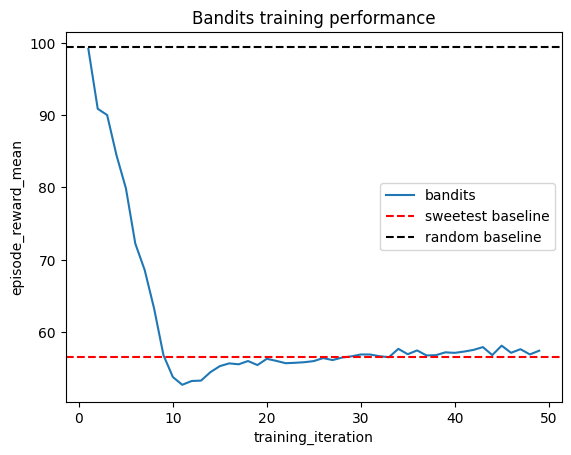

In [22]:
sns.lineplot(data=df, x="training_iteration", y="episode_reward_mean", label="bandits")
plt.axhline(sweetest_baseline, color="red", linestyle='--', label="sweetest baseline")
plt.axhline(random_baseline, color="k", linestyle='--', label="random baseline")

plt.legend()
plt.title('Bandits training performance')

### Compare the Bandit Training results to Baseline
- Bandit Mean Reward=~56 
- Kaleist (Argmin) Baseline Mean Reward = ~10.87+/-0.26
- Random Baseline Mean Reward = ~99.90+/-23.75
- Sweetest (Argmax) Baseline Mean Reward = ~56.56+/-1.37

<div class="alert alert-block alert-success">
    🤔  <b>Bandit mean reward is approx the same as the sweetest baseline!</b> 
</div>  

Try the code block below to compare what the bandit recommends with what is the sweetest item... you will see that the bandit always recommends the sweetest item!

In [23]:
# build the algorithm and load from checkpoint
with open("saved_runs/bandits/params.pkl", 'rb') as f:
    params = pickle.load(f)

pprint(params)

{'_disable_action_flattening': False,
 '_disable_execution_plan_api': True,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'adam_epsilon': 1e-08,
 'always_attach_evaluation_results': False,
 'batch_mode': 'complete_episodes',
 'before_learn_on_batch': None,
 'buffer_size': -1,
 'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': -1,
 'compress_observations': False,
 'create_env_on_driver': True,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'disable_env_checking': False,
 'double_q': True,
 'dueling': False,
 'eager_max_retraces': 20,
 'eager_tracing': False,
 'enable_connectors': False,
 'enable_tf1_exec_eagerly': False,
 'env': 'modified-lts',
 'env_config': {'num_candidates': 20,
                'resample_documents': True,
                'reward

In [24]:
# bandit_config.build()
bandit_algo = DQN(params)
bandit_algo

2022-09-13 19:15:22,951	WARNING algorithm.py:2325 -- `evaluation_parallel_to_training` can only be done if `evaluation_num_workers` > 0! Setting `evaluation_parallel_to_training` to False.
2022-09-13 19:15:22,952	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2022-09-13 19:15:27,843	WARNING util.py:66 -- Install gputil for GPU system monitoring.


DQN

In [26]:
# TODO (exercise): Load the checkpoint from the result folder of your running script
# checkpoint = "saved_runs/bandits/checkpoint_000097"
checkpoint = "results_scripts/online_rl/bandits/DQN_modified-lts_673bf_00000_0_2022-09-13_18-56-12/checkpoint_000018"
bandit_algo.restore(checkpoint)

2022-09-13 19:16:32,392	INFO trainable.py:691 -- Restored on 10.0.108.203 from checkpoint: results_scripts/online_rl/bandits/DQN_modified-lts_673bf_00000_0_2022-09-13_18-56-12/checkpoint_000018
2022-09-13 19:16:32,392	INFO trainable.py:700 -- Current state after restoring: {'_iteration': 18, '_timesteps_total': None, '_time_total': 1181.6003487110138, '_episodes_total': 1800}


In [27]:
env = ModifiedLongTermSatisfactionRecSimEnv(env_config)
obs = env.reset()

# Run a single episode.
done = False
while not done:
    # Pass the single (unbatched) observation into the `compute_single_action` method of our Trainer.
    # This is one way to perform inference on a learned policy.
    bandit_action = bandit_algo.compute_single_action(input_dict={"obs": obs})
    argmax_action = int(max(obs['doc'], key=lambda x: obs['doc'][x]))

    feature_value_of_bandit = obs["doc"][str(bandit_action)]
    feature_value_of_greedy = obs["doc"][str(argmax_action)]


    # Print out the picked document's feature value and compare that to the highest possible feature value.
    print("-"*50)
    print("observation_features: ", np.concatenate(list(obs["doc"].values())))
    print(f"bandit's feature value={feature_value_of_bandit}; argmax feature={feature_value_of_greedy};")

    # Apply the computed action in the environment and continue.
    obs, r, done, _ = env.step(action)

--------------------------------------------------
observation_features:  [0.88634086 0.18800597 0.9635299  0.06722239 0.8350821  0.07456641
 0.8011377  0.05048527 0.9591325  0.00305099 0.9197687  0.12076091
 0.82102954 0.07638869 0.8072952  0.17808232 0.9961842  0.0119884
 0.9781092  0.1153803 ]
bandit's feature value=[0.9781092]; argmax feature=[0.9961842];
--------------------------------------------------
observation_features:  [0.9484959  0.1260368  0.9163684  0.00408783 0.8420053  0.10893697
 0.95382303 0.05013905 0.85717916 0.17047901 0.9950013  0.17697066
 0.8719016  0.11977179 0.8709591  0.06803805 0.8356162  0.04753884
 0.8089725  0.10108629]
bandit's feature value=[0.9484959]; argmax feature=[0.9950013];
--------------------------------------------------
observation_features:  [0.8752505  0.11856108 0.9259884  0.02852006 0.98676825 0.18927598
 0.92045933 0.07755326 0.8726376  0.04086906 0.855353   0.04930717
 0.8347216  0.19332194 0.9914025  0.11959474 0.94626015 0.06807704


In this dummy Recsim environment, we did not have any user features.  This makes the contextual bandit without any user context, i.e. without any state.  A stateless bandit cannot remember things between timesteps, so it will sort of converge to the most greedy policy that recommends chocolotes.

### Solving the problem with RL

So far the bandit solution has just converged to the perforamnce of greedy argmax policy. **How can we improve over the random policy baseline** Now let's run the DQN algorithm with $\gamma = 1.0$. We run this script for 1M enviroenment timesteps till convergence. It will take ~ 1hour to run this training job.

**Exercise (1 min)** How would you modify the previous config object to train an RL agent to optimize long-term engagement (hint: it's a single parameter that needs to be updated)?


You can run the same script as before, with `gamma=1.0` passed in as a parameter. We should also run the script longer (1M steps) as it will take longer for DQN to converge. 
```bash
python tutorial_scripts/run_online_rl.py --seed 0 --gamma 1.0 --exp_name dqn --timesteps 1_000_000
```

In [28]:
# TODO (exercise): Code here
dqn_config = bandit_config.training(gamma=1.0)

tuner = tune.Tuner(
    DQN,
    param_space=dqn_config.to_dict(),
    run_config=air.RunConfig(
        local_dir='./results_notebook/online_rl/dqn',
        stop={"training_iteration": 1},  # this is enough for it to converge
    )
)
dqn_results = tuner.fit()

(DQN pid=86222) 2022-09-13 19:16:57,771	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
(DQN pid=86222) 2022-09-13 19:16:57,772	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
(DQN pid=86222) 2022-09-13 19:16:57,772	INFO simple_q.py:303 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
(DQN pid=86222) 2022-09-13 19:16:57,774	INFO algorithm.py:357 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(DQN pid=86222) 2022-09-13 19:16:57,793	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps 

Trial name,agent_timesteps_total,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_recreated_workers,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
DQN_modified-lts_4be6c_00000,1000,"{'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",{},2022-09-13_19-17-02,True,10,{},173.287,98.3798,44.7961,100,100,88ab94adb69b4639a7744c3e6c242ded,ip-10-0-108-203,"{'learner': {}, 'num_env_steps_sampled': 1000, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 0}",1,10.0.108.203,1000,0,1000,1000,0,0,0,0,0,0,"{'cpu_util_percent': 35.67142857142857, 'ram_util_percent': 22.800000000000004}",86222,{},{},{},"{'mean_raw_obs_processing_ms': 1.6825222945237144, 'mean_inference_ms': 1.805628453577672, 'mean_action_processing_ms': 0.06444518501822885, 'mean_env_wait_ms': 0.40582867411824003, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 173.2868223797043, 'episode_reward_min': 44.79612402386947, 'episode_reward_mean': 98.37975885525839, 'episode_len_mean': 10.0, 'episode_media': {}, 'episodes_this_iter': 100, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [117.13539011539619, 70.40936456055186, 95.27865296623575, 111.31291700671765, 102.64162729227571, 101.53479063478456, 46.64754895018614, 97.68445619587654, 83.14155238819997, 116.58315565407071, 77.21296890875313, 99.69110715612564, 99.63877531283535, 92.12971795015105, 98.80723485511153, 128.2309849854803, 114.65164691934496, 74.45375495384087, 97.31512410116683, 84.36382430096995, 66.92182368715324, 95.20658973661612, 96.73532758306509, 107.00982964142618, 93.45881518511352, 139.75757003066943, 68.18534157558396, 109.4536319941096, 63.657624783404565, 44.79612402386947, 67.35550971768012, 121.9387501332986, 98.72183485788901, 70.5020406473111, 99.82819073075672, 49.81055329921299, 93.07634629933538, 100.58721530664666, 107.20416475849865, 118.31037109611547, 136.3662730758918, 116.92002759296476, 104.87628450315948, 125.119427328972, 141.79822276510546, 132.2884282578209, 127.2585937707536, 84.76716074952427, 67.21745586340036, 96.32163146867828, 95.51320348968845, 133.3478674922118, 86.95553324925451, 94.19401802245761, 59.08976864766805, 75.96855561393625, 105.07258261467523, 98.14072494213772, 90.80363762131311, 84.4510590738594, 97.88380534727045, 103.14971758513141, 113.18923590593845, 103.24636585927767, 64.9761180722668, 101.18731871272716, 94.36294921805124, 98.75302834378347, 82.33076498960753, 88.80600002188318, 96.95546256902168, 122.23301875294428, 104.98247390809442, 102.63504110360128, 89.50790086850101, 124.48339468839016, 125.75072869898686, 112.34036623838422, 106.21724607618883, 96.66871164938297, 68.39294188160419, 127.80793055981, 99.79973013038185, 117.87567576402886, 104.49636418887808, 114.82524707514688, 65.74080033223946, 150.14902815936813, 65.77809651360234, 111.67060646382683, 129.24744198841066, 72.65984242520635, 95.71599094926961, 120.78569757313275, 173.2868223797043, 90.87397138699302, 74.72075528456872, 76.77522316667317, 69.91266101033389, 99.94870324392488], 'episode_lengths': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

2022-09-13 19:17:02,912	INFO tune.py:762 -- Total run time: 10.63 seconds (9.91 seconds for the tuning loop).


**Exercise** Take a look at the results and compare them to bandits via tensorboard.

In [29]:
# take a look at the results (hint: use pd.read_csv)
bandit_df = pd.read_csv("saved_runs/bandits/progress.csv")
dqn_df = pd.read_csv("saved_runs/dqn/progress.csv")

Text(0.5, 1.0, 'RL vs. Bandits training performance')

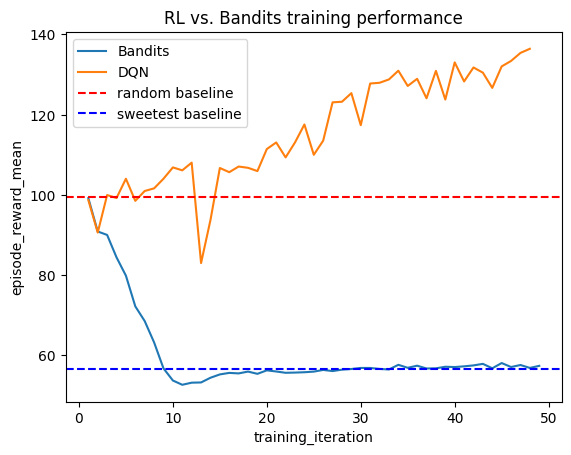

In [30]:
# plot the results and compare to baselines
sns.lineplot(data=bandit_df, x="training_iteration", y="episode_reward_mean", label="Bandits")
sns.lineplot(data=dqn_df, x="training_iteration", y="episode_reward_mean", label="DQN")
plt.axhline(random_baseline, color="red", linestyle='--', label="random baseline")
plt.axhline(sweetest_baseline, color="blue", linestyle='--', label="sweetest baseline")
plt.legend()
plt.title('RL vs. Bandits training performance')


- **Sweetest** straight line, is the mean reward achieved by the greedy policy, selecting always the item with most immediate reward value.
- **Bandit** short term reward hovers around the "sweetest baseline".
- **Random** straight line, items are randomly chosen to be recommended at each timestep. Since this baseline mixes the sweetest and kaliest options the engagement is kept higher than either of the greedy methods, obtaining larger rewards.
- **DQN (RL)**, such as DQN that optimize for long-term engagement significantly improves upon random baselines.

# Questions and Break (5 min)

## Offline RL with RecSys

<img src="images/offline_rl.png">


### If we don't have a live environment, how do we know, how well our trained policy will perform?

One of the challenges in offline RL is the evaluation of the trained policy. In online RL (when a simulator
is available), one can either use the data collected for training to compute episode total rewards. Remember
that observations, actions, rewards, and done flags are all part of this training data. Alternatively,
one could run a separate worker (with the same trained policy) and run it on a fresh evaluation-only environment.
In this latter case, we would also have the chance to switch off any exploratory behavior (e.g. stochasticity used
for better action entropy).

In offline RL, no such data from a live environment is available to us. There are two common ways of addressing this dilemma:

1) We deploy the learned policies into production, or maybe just a portion of our production system (similar to A/B testing), and see what happens.

2) We use a method called "off policy evaluation" (OPE) to compute an estimate on how the new policy would perform if we were to deploy it into a real environment. There are different OPE methods available in RLlib off-the-shelf.

3) The third option - which we will use here - is kind of cheating and only possible if you actually do have a simulator available (but you only want to use it for evaluation, not for training, because you want to see how cool offline RL is :) )

In this tutorial, we will use the third option to show the effectiveness of offline RL in improving over existing policies running in production. We will also see how much benefit we can get by improving our dataset quality, starting from a totally random policy all the way to 20% expert demonstrations adn 80% random. 

We can use the currently running policies in production to collect some "historical data" that we can use to train RL agents with. Offline RL can be used to improve upon the existing policies deployed in production. We have prepared some datasets in advance for the purpose of this tutorial. They were all generated using `<path to the script>`. In this script we can mix the percentage of the "expert" data vs. random data to investigate the effect of dataset quality on the final performance of our models.   

Let's look at an exemplar dataset we have prepared before:



In [31]:
prefix = "s3://air-example-data/rllib/acm_recsys22_tutorial_data/"
train_data_path = prefix + "sampled_data_train_random_expert_1_percent_transitions"

dset = data.read_json(train_data_path)
df = dset.to_pandas()
print('Colimns: ', df.columns)
print('Number of rows: ', len(df))
print('Value of the first row')
print('-'*20)
print(df.iloc[0])
print('Value of the second row:')
print('-'*20)
print(df.iloc[1])


2022-09-13 19:17:03,364	WARNING read_api.py:291 -- ⚠️  The number of blocks in this dataset (3) limits its parallelism to 3 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Read progress: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Colimns:  Index(['type', 'obs', 'new_obs', 'actions', 'rewards', 'dones', 'eps_id', 't',
       'action_prob'],
      dtype='object')
Number of rows:  100000
Value of the first row
--------------------
type                                                 SampleBatch
obs            BCJNGGhAMAQAAAAAAACKIwIAAGGABZUlBAABAPEcjBVudW...
new_obs        BCJNGGhALQQAAAAAAABmHgIAAGGABZUiBAABAPEcjBVudW...
actions                                                      [5]
rewards                                      [1.514441695837177]
dones                                                    [False]
eps_id                                                       [0]
t                                                            [0]
action_prob                                               [0.05]
Name: 0, dtype: object
Value of the second row:
--------------------
type                                                 SampleBatch
obs            BCJNGGhALQQAAAAAAABmHgIAAGGABZUiBAABAPEcjBVudW...
new_obs       

From the dataset schema, we can see that RLlib always expects a `type` column that is `SampleBatch`. It will have the normal transition entities per each row (i.e. observation, next_observation, action, reward, done values). It will also contain an episode_id, a timestep indicator, and an action_prob that show the probablity of the action that we chosen at the time of data collection. For random policy the action prob will always be 1/20 (0.05). 

Now that we have an understaning of the dataset example format, we can use RLlib to train an offline RL algorithm. RLlib provides several out of the box offline RL algorithms that you can use. Beside those offline-RL-specific algorithms, we can also use any off-policy algorithm (e.g. DQN) to do offline-RL. The only difference between online and offline version is that instead of using an enviornement sampler, we use a dataset sampler to get the data from. In the next section, we will use DQN, with the difference that we pass a dataset path to the input config.

Here is the summary of the differences:

- Change the input config from a sample to offline dataset is configured by `.offline_data()` API:

```python
    .offline_data(
        input_='dataset',
        input_config={
            'format': 'json',
            'paths': <path to the json directory>
        }
    )
```

- The environement is not passed to the enviornement anymore. Instead we need to pass in the expected action and observation space to construct the policies. We can create them manually based on our knowledge of our system. In this case we actually cheat and use the environement attributes to get the correct action and observatin spaces.

```python 
    .environment(
        action_space=action_space,
        observation_space=observation_space,
    )
```

- evaluation config: Since during the evaluation we still need to use the enviroenement simulations, we need to specify it explicitly here. RLlib by default will use the training settings during evaluation and to avoid that default behavior we need to explicitly specify the simulation environement configs. 

```python
    .evaluation(
        evaluation_config={
            "input": "sampler",
            "explore": False,
            "env": "modified-lts",
            "env_config": env_config_20,
        },
    )
```

- (Advanced) configuring the replay buffer to become a dummy buffer. By default RLlib uses a large replay buffer that is useful in online RL but doesn't add much value in the offline case. It is recommended to by-pass this behavior by configuring the replay buffer size to be the same as the dataset sampling size, so that the sampling flow does not get dirupted by the replay buffer behavior.

```python
    .training(
        replay_buffer_config={
            "capacity": 512,
            "learning_starts": 0
        }
    )

```

Running the script below takes about 1 hour. 

In [32]:
env = ModifiedLongTermSatisfactionRecSimEnv(env_config)
action_space = env.action_space
observation_space = env.observation_space

dqn_config_offline = (
    dqn_config
    .offline_data(
        input_='dataset',
        input_config={
            'format': 'json',
            'paths': train_data_path,
        }
    )
    .environment(
        action_space=action_space,
        observation_space=observation_space,
    )
    .evaluation(
        evaluation_interval=10, 
        evaluation_duration=10, 
        evaluation_duration_unit="episodes",
        evaluation_parallel_to_training=True,
        evaluation_config={
            "input": "sampler",
            "explore": False,
            "env": "modified-lts",
            "env_config": env_config,
        },
    )
    .debugging(seed=seed, log_level="ERROR")
    .training(
        gamma=1.0,
        num_atoms=1,
        double_q=True,
        dueling=False,
        model=dict(
            fcnet_hiddens=[1024, 1024, 1024],
            fcnet_activation='relu', 
        ),
        train_batch_size=512,
        lr=3e-4,
        target_network_update_freq=512,
        replay_buffer_config={
            "capacity": 512,
            "learning_starts": 0
        }
    )
)

To run the long-running learning script run:

```bash
python tutorial_scripts/run_offline_rl.py --dataset_suffix sampled_data_train_random_transitions
```

In [33]:
tuner = tune.Tuner(
    DQN,
    param_space=dqn_config_offline.to_dict(),
    run_config=air.RunConfig(
        local_dir="./results_notebook/offline_rl/",
        stop={"training_iteration": 1},
    )
)
dqn_offline_results = tuner.fit()

(DQN pid=87362) 2022-09-13 19:17:14,037	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
(DQN pid=87362) 2022-09-13 19:17:14,039	WARNING algorithm.py:2325 -- `evaluation_parallel_to_training` can only be done if `evaluation_num_workers` > 0! Setting `evaluation_parallel_to_training` to False.
(DQN pid=87362) 2022-09-13 19:17:14,039	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
(DQN pid=87362) 2022-09-13 19:17:14,040	INFO simple_q.py:303 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
(DQN pid=87362) 2022-09-13 19:17:14,041	INFO algorithm.py:357 -- Current log_level

(DQN pid=87362) DatasetReader 0 has 100000, samples.


(DQN pid=87362) 2022-09-13 19:17:22,510	WARNING util.py:66 -- Install gputil for GPU system monitoring.


2022-09-13 19:17:27,543	WARNING worker.py:1828 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 47bb0afc92e3612fe1559472108d921a6b73b70705000000 Worker ID: 740642704500d26173624ac8b0b3668852d1175404b58653c1f35061 Node ID: d24bac42debb9c890faca8f7fc4ebca311d02235309081475ad226cc Worker IP address: 10.0.108.203 Worker port: 10027 Worker PID: 88361 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
2022-09-13 19:17:27,579	INFO tune.py:762 -- Total run time: 18.77 seconds (18.54 seconds for the tuning loop).


Let's now look at the offline training results. From the plot below we can see that by running offline RL on randomly collected transitions we can improve over the random policy. This is extremely useful in practical scenarios where our goal is to improve over existing production policies.

In [34]:
dqn_offline_results


In [35]:
dqn_offline_results[0].metrics

{'custom_metrics': {},
 'episode_media': {},
 'num_recreated_workers': 0,
 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0,
     'grad_gnorm': 10.659525871276855,
     'mean_q': 0.17704549431800842,
     'min_q': -4.844664096832275,
     'max_q': 6.565323829650879,
     'cur_lr': 0.0003},
    'td_error': array([-1.01045489e+00, -2.51343989e+00, -1.27970994e+00, -2.57820272e+00,
           -4.76473951e+00, -1.24300218e+00, -2.21681404e+00, -2.39070778e+01,
           -1.83681011e+00, -1.48040116e+00, -4.30534935e+00, -4.20912647e+00,
           -1.51498580e+00, -3.61302719e+01, -1.64095640e+00, -2.97871895e+01,
           -1.33836925e+00, -2.28126984e+01, -3.73060703e+00, -1.63411236e+00,
           -2.42731380e+00, -6.23242378e+01, -1.08215780e+01, -1.06195793e+01,
           -7.51569748e-01, -3.45309410e+01, -1.22364521e+00, -2.11540723e+00,
           -1.49532118e+01, -7.88946581e+00, -1.03518019e+01, -1.10470610e+01,
           -1.33602059e+00, -2.

In [36]:
# plot the results and compare to baselines
fname = "saved_runs/dqn_offline/random_data/progress.csv"
offline_dqn_df = pd.read_csv(fname)
offline_dqn_df


,num_recreated_workers,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_faulty_episodes,num_healthy_workers,num_agent_steps_sampled,num_agent_steps_trained,...,sampler_results/hist_stats/episode_lengths,info/learner/default_policy/td_error,info/learner/default_policy/mean_td_error,info/learner/default_policy/num_agent_steps_trained,info/learner/default_policy/learner_stats/allreduce_latency,info/learner/default_policy/learner_stats/grad_gnorm,info/learner/default_policy/learner_stats/mean_q,info/learner/default_policy/learner_stats/min_q,info/learner/default_policy/learner_stats/max_q,info/learner/default_policy/learner_stats/cur_lr
0,0,NaN,NaN,NaN,NaN,0,0,1,512,512,...,[],[-2.3538213e+00 -1.1375945e+00 -1.2462333e+01 ...,-10.580702,512.0,0.0,40.0,0.213455,-4.432943,6.774650,0.0003
1,0,NaN,NaN,NaN,NaN,0,0,1,1024,1024,...,[],[-40.506775 -61.97426 -38.595753 -3.70...,-11.315735,512.0,0.0,40.0,1.039853,-10.420587,17.475670,0.0003
2,0,NaN,NaN,NaN,NaN,0,0,1,1536,1536,...,[],[-31.038172 -3.1823516 -32.29229 -21.26...,-13.161014,512.0,0.0,40.0,1.195285,-3.818083,14.747209,0.0003
3,0,NaN,NaN,NaN,NaN,0,0,1,2048,2048,...,[],[ -4.3287826 -19.507774 -47.811214 -...,-13.706473,512.0,0.0,40.0,2.172622,-4.584808,24.536005,0.0003
4,0,NaN,NaN,NaN,NaN,0,0,1,2560,2560,...,[],[-4.65406561e+00 1.47419739e+00 -2.03024578e+...,-13.847671,512.0,0.0,40.0,2.783419,-4.468198,37.622391,0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,0,NaN,NaN,NaN,NaN,0,0,1,998400,998400,...,[],[-1.43014526e+00 7.04738808e+00 1.69252281e+...,-1.033876,512.0,0.0,40.0,84.962700,2.396049,177.688889,0.0003
1950,0,NaN,NaN,NaN,NaN,0,0,1,998912,998912,...,[],[ -2.5442238 -5.1743317 2.5995522 2.14...,0.221676,512.0,0.0,40.0,85.822052,3.665074,178.535477,0.0003
1951,0,NaN,NaN,NaN,NaN,0,0,1,999424,999424,...,[],[-5.74981689e-01 -3.20867157e+00 7.30127335e+...,0.515675,512.0,0.0,40.0,81.784767,2.501043,181.170700,0.0003
1952,0,NaN,NaN,NaN,NaN,0,0,1,999936,999936,...,[],[ 1.62049751e+01 1.76564312e+00 7.05337524e-...,0.951557,512.0,0.0,40.0,78.297279,4.202184,178.099579,0.0003


Text(0.5, 1.0, 'Offline RL vs. Baselines training performance')

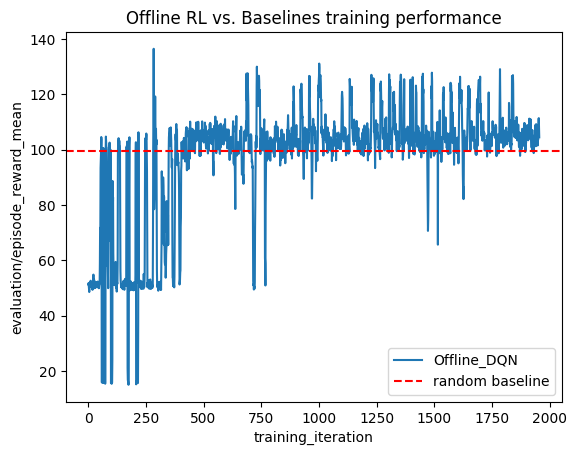

In [37]:

sns.lineplot(data=offline_dqn_df, x="training_iteration", y="evaluation/episode_reward_mean", label="Offline_DQN")
plt.axhline(random_baseline, color="red", linestyle='--', label="random baseline")
plt.legend()
plt.title('Offline RL vs. Baselines training performance')

Text(0.5, 1.0, 'Average Q value')

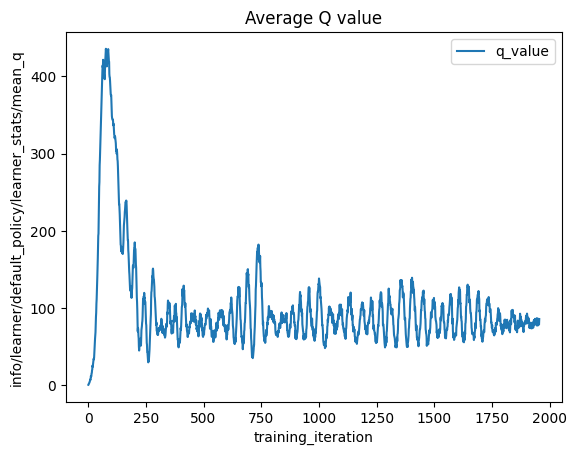

In [38]:
sns.lineplot(data=offline_dqn_df, x="training_iteration", y="info/learner/default_policy/learner_stats/mean_q", label="q_value")
plt.legend()
plt.title('Average Q value')

### Conclusion
